In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import glob
import tensorflow as tf

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

# このSprintについて

## Sprintの目的
- 自然言語処理の一連の流れを学ぶ
- 自然言語のベクトル化の方法を学ぶ
- 仕事の簡略化に使えそうな部分を想起しながら課題に挑む
- ただの作業にならないように、萎えてきたら上記に戻る

## どのように学ぶか
自然言語処理定番のデータセットを用いて、一連の流れを見ていきます。

→**定番のデータセットだってさ！**

# 自然言語のベクトル化
自然言語処理とは人間が普段使っている自然言語をコンピュータに処理させる技術のことです。ここではその中でも、機械学習の入力として自然言語を用いることを考えていきます。

多くの機械学習手法は数値データ(量的変数)の入力を前提にしていますので、自然言語のテキストデータを数値データに変換する必要があります。これを自然言語のベクトル化と呼びます。ベクトル化の際にテキストデータの特徴をうまく捉えられるよう、様々な手法が考えられてきていますので、このSprintではそれらを学びます。

→**ベクトル化の手法は手法が様々あるが、それをこのSprintでは学ぶ。**

## 非構造化データ
データの分類として、表に数値がまとめられたようなコンピュータが扱いやすい形を構造化データ、人間が扱いやすい画像・動画・テキスト・音声などを非構造化データと呼ぶことがあります。自然言語のベクトル化は、非構造化データを構造化データに変換する工程と言えます。同じ非構造化データでも、画像に対してはディープラーニングを用いる場合この変換作業はあまり必要がありませんでしたが、テキストにおいてはこれをどう行うかが重要です。

→**テキストという非構造化データをいかに構造化データに変換するかが肝になってくる。**

## 自然言語処理により何ができるか
機械学習の入力や出力に自然言語のテキストを用いることで様々なことができます。入力も出力もテキストである例としては機械翻訳があげられ、実用化されています。入力は画像で出力がテキストである画像キャプション生成やその逆の文章からの画像生成も研究が進んでいます。

しかし、出力をテキストや画像のような非構造化データとすることは難易度が高いです。比較的簡単にできることとしては、入力をテキスト、出力をカテゴリーとするテキスト分類です。

アヤメやタイタニック、手書きの数字のような定番の存在として、IMDB映画レビューデータセットの感情分析があります。レビューの文書が映画に対して肯定的か否定的かを２値分類します。文書ごとの肯定・否定はラベルが与えられています。このSprintではこれを使っていきます。

→**自然言語処理の比較的簡単な手法として出力をカテゴリーとして分類するテキスト分類を行う。その中でも定番のデータセットを用いて、２値分類を行っていく。**

# IMDB映画レビューデータセットの準備
IMDB映画レビューデータセットを準備します。

## ダウンロード
次のwgetコマンドによってダウンロードします。

In [19]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/')

In [2]:
#IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2021-04-09 18:00:29--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
ai.stanford.edu (ai.stanford.edu) をDNSに問いあわせています... 171.64.68.10
ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 84125825 (80M) [application/x-gzip]
`aclImdb_v1.tar.gz' に保存中

aclImdb_v1.tar.gz   100%[===================>]  80.23M  12.0MB/s 時間 15s        

2021-04-09 18:00:44 (5.35 MB/s) - `aclImdb_v1.tar.gz' へ保存完了 [84125825/84125825]



In [3]:
# 解凍
!tar zxf aclImdb_v1.tar.gz

In [4]:
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup

In [ ]:
# IMDBデータセットの説明を表示
!cat aclImdb/README

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

Large Movie Review Dataset v1.0

概要

このデータセットは、映画のレビューと、それに関連する二値のセンチメント極性ラベルを含んでいます。センチメント分類のベンチマークとして使用することを目的としています。このドキュメントでは，データセットの収集方法と，提供されたファイルの使用方法について説明します．

データセット 

コアデータセットには、50,000件のレビューが含まれており、25kのトレーニングセットと25kのテストセットに均等に分割されています。ラベルの分布は全体的にバランスが取れています（25k pos and 25k neg）。また、教師なし学習のために、さらに50,000のラベルなしの文書を含んでいます。

同じ映画に対するレビューは相関性のある評価を持つ傾向があるため、コレクション全体では、任意の映画に対して30件以上のレビューは許可されていません。また，訓練セットとテストセットには，それぞれ独立した映画が含まれているため，映画固有の用語や，それに関連して観測されたラベルを記憶しても，大きな性能は得られない． ラベル付きのトレーニング/テストセットでは、否定的なレビューは10点満点中4点未満、肯定的なレビューは10点満点中7点以上となります。したがって，中立的な評価を持つレビューは，訓練/テストセットには含まれません．教師なしセットでは、任意の評価のレビューが含まれており、>5 と <= 5 のレビューが偶数個存在します。

ファイル

トレーニングセットとテストセットに対応する2つのトップレベルディレクトリ[train/, test/]があります。
トレーニングセットとテストセットに対応しています。それぞれに、ポジティブとネガティブのバイナリラベルを持つレビューの[pos/, neg/]ディレクトリがあります。これらのディレクトリには，レビューが[[id]_[rating].txt]という名前のテキストファイルとして格納されています。ここで，[id]は一意のID，[rating]はそのレビューに対する1～10の星の評価です。例えば，[test/pos/200_8.txt]は，IMDbに登録されているユニークID200，星評価8/10のポジティブラベル付きテストセット例のテキストです．train/unsup/]ディレクトリには、すべての評価が0となっていますが、これはデータセットのこの部分では評価が省略されているためです。

また、各レビューのIMDbのURLを別の[urls_[pos, neg, unsup].txt]ファイルに記載しています。ユニークIDが200のレビューのURLは、このファイルの200行目に記載されています。IMDbは常に変化しているため、レビューに直接リンクすることはできず、映画のレビューページにのみリンクします。

レビューのテキストファイルに加えて、実験で使用された、すでにトークン化されたバッグ・オブ・ワーズ（BoW）の特徴も含まれています。これらは、train/testディレクトリ内の.featファイルに格納されています。各.featファイルは，ラベル付きデータ用のアスキー・スパース・ベクトル形式であるLIBSVMフォーマットです。 これらのファイルの特徴のインデックスは0から始まり、特徴のインデックスに対応するテキストトークンは[imdb.vocab]にあります。つまり、.featファイルの0:7の行は、[imdb.vocab]の最初の単語(the)がそのレビューに7回登場することを意味します。

.featファイル形式の詳細についてはLIBSVMのページを参照してください： http://www.csie.ntu.edu.tw/~cjlin/libsvm/

また、[imdb.vocab]に含まれる各トークンについて、(Potts, 2011)によって計算された期待される評価を含む[imdbEr.txt]も含まれています。期待される評価は、データセット内の単語の平均的な極性を知るための良い方法です。

データセットの引用

このデータセットを使用する際には，このデータセットを紹介したACL2011の論文を引用してください．この論文には分類結果も含まれていますので、それと比較するのもよいでしょう。

以下のサイトで公開されているデータセットです。

http://ai.stanford.edu/~amaas/data/sentiment/

## 読み込み
scikit-learnのload_filesを用いて読み込みます。

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_files.html

《読み込むコード》

In [5]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


## このデータセットについて
中身を見てみると、英語の文章が入っていることが分かります。

In [6]:
print("x : {}".format(x_train[0]))
print("y : {}".format(y_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.
y : 1


IMDBはInternet Movie Databaseの略で、映画のデータベースサイトです。

https://www.imdb.com/

このサイトではユーザが映画に対して１から１０点の評価とコメントを投稿することができます。そのデータベースから訓練データは２５０００件、テストデータは２５０００件のデータセットを作成しています。

４点以下を否定的、７点以下を肯定的なレビューとして２値のラベル付けしており、これにより感情の分類を行います。５，６点の中立的なレビューはデータセットに含んでいません。また、ラベルは訓練用・テスト用それぞれで均一に入っています。詳細はダウンロードしたREADMEを確認してください。

# 古典的な手法

古典的ながら現在でも強力な手法であるBoWとTF-IDFを見ていきます。

# BoW

単純ながら効果的な方法としてBoW(Bag of Words)があります。これは、サンプルごとに単語などの登場回数を数えたものをベクトルとする方法です。単語をカテゴリとして捉えone-hot表現していることになります。

## 例
例として、IMDBデータセットからある３文の最初の５単語を抜き出したものを用意しました。

In [7]:
mini_dataset = \
["This movie is very good.", 
 "This film is a good", 
 "Very bad. Very, Very bad."
 ]

この３文にBoWを適用させてみます。scikit-learnのCountVectorizerを利用します。

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html


In [8]:
import pandas as pd

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')

In [11]:
bow = (vectorizer.fit_transform(mini_dataset)).toarray()

In [12]:
#DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())

実行すると次のような表が得られます。

In [13]:
display(df)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


例にあげた３文の中で登場する８種類の単語が列名になり、０，１，２番目のサンプルでそれらが何回登場しているかを示しています。２番目のサンプル「Very bad. Very, very bad.」ではbadが２回、veryが３回登場しています。列名になっている言葉はデータセットが持つ語彙と呼びます。

テキストはBoWにより各サンプルが語彙数の次元を持つ特徴量となり、機械学習モデルへ入力できるようになります。この時使用したテキスト全体のことをコーパスと呼びます。語彙はコーパスに含まれる言葉によって決まり、それを特徴量としてモデルの学習を行います。そのため、テストデータではじめて登場する語彙はベクトル化される際に無視されます。

## 前処理
CountVectorizerでは大文字は小文字に揃えるという前処理が自動的に行われています。こういった前処理は自然言語処理において大切で、不要な記号などの消去(テキストクリーニング)や表記揺れの統一といったことを別途行うことが一般的です。

語形が「see」 「saw」 「seen」 のように変化する単語に対して語幹に揃えるステミングと呼ばれる処理を行うこともあります。

## トークン
BoWは厳密には単語を数えているのではなく、トークン(token)として定めた固まりを数えます。

何をトークンとするかはCountVectorizerでは引数token_patternで正規表現の記法により指定されます。デフォルトではr'(?u)\b\w\w+\b'ですが、上の例ではr'(?u)\b\w+\b'としています。

デフォルトでは空白・句読点・スラッシュなどに囲まれた２文字以上の文字を１つのトークンとして抜き出すようになっているため、「a」や「I」などがカウントされません。英語では1文字の単語は文章の特徴をあまり表さないため、除外されることもあります。しかし、上の例では１文字の単語もトークンとして抜き出すように引数を指定しています。

《正規表現》

正規表現は前処理の際にも活用しますが、ここでは詳細は扱いません。Pythonではreモジュールによって正規表現操作ができます。

https://docs.python.org/ja/3/library/re.html

正規表現を利用する際はリアルタイムで結果を確認できる以下のサービスが便利です。　

https://regex101.com/

## 形態素解析

英語などの多くの言語では空白という分かりやすい基準でトークン化が行えますが、日本語ではそれが行なえません。

日本語では名詞や助詞、動詞のように異なる品詞で分けられる単位で分かち書きすることになります。例えば「私はプログラミングを学びます」という日本語の文は「私/は/プログラミング/を/学び/ます」という風になります。

これにはMeCabやJanomeのような形態素解析ツールを用います。Pythonから利用することも可能です。MeCabをウェブ上で簡単に利用できる http://chamame.ninjal.ac.jp/ というサービスも国立国語研究所が提供しています。

自然言語では新しい言葉も日々生まれますので、それにどれだけ対応できるかも大切です。MeCab用の毎週更新される辞書としてmecab-ipadic-NEologdがオープンソースで存在しています。

https://github.com/neologd/mecab-ipadic-neologd/blob/master/README.ja.md

## n-gram
上のBoWの例では１つの単語(トークン)毎の登場回数を数えましたが、これでは語順はまったく考慮されていません。

考慮するために、隣あう単語同士をまとめて扱うn-gramという考え方を適用することがあります。２つの単語をまとめる場合は２-gram（bigram）と呼び、次のようになります。

In [14]:
#ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')

In [15]:
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()

In [16]:
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())

In [17]:
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


2-gramにより「very good」と「very bad」が区別して数えられています。

単語をまとめない場合は1-gram(unigram)と呼びます。３つまとめる3-gram(trigram)など任意の数を考えることができます。1-gramと2-gramを組み合わせてBoWを行うといったこともあります。

## 【問題１】BoWのスクラッチ実装
以下の３文のBoWを求められるプログラムをscikit-learnを使わずに作成してください。1-gramと2-gramで計算してください。

This movie is SOOOO funny!!!

What a movie! never

best movie ever!!!!! this movie

In [18]:
mini_dataset = \
["This movie is SOOOO funny!!!", 
 "What a movie! I never", 
 "best movie ever!!!!! this movie"]

## 関数化

In [19]:
def scratch_BoW(dataset, n=1):
  #indexは行の左端のところ。今回でいうと、rangeが３だから０，１，２になる
  df = pd.DataFrame(index=range(len(dataset)))
  #dataはmini_datasetの１行ずつが入っている
  for i, data in enumerate(dataset):
    #make_word_listでクリーニングとスペースで単語ごとに区切っている
    word_list0 = make_word_list(data)
    print(word_list0)
    word_list = [" ".join(word_list0[i:i+n]) for i in range(len(word_list0) - (n-1))]
    print(word_list)
    for word in word_list:
      if word not in df.columns:
        df[word] = 0
      df.loc[i, word] += 1
  #たぶん単語が見やすいようにアルファベット順に並べ直してる
  df_s = df.sort_index(axis=1)
  return df_s

#ここでクリーニングやっている。replaceと小文字の置き換えした後に半角スペースで区切っている
def make_word_list(sentence):
  sentence = sentence.replace(",", "").replace(".", "").replace("!", "").replace("<br/>", "").replace("/", "and").lower()
  return sentence.split(" ")

In [20]:
df = scratch_BoW(mini_dataset, n=2)
df

['this', 'movie', 'is', 'soooo', 'funny']
['this movie', 'movie is', 'is soooo', 'soooo funny']
['what', 'a', 'movie', 'i', 'never']
['what a', 'a movie', 'movie i', 'i never']
['best', 'movie', 'ever', 'this', 'movie']
['best movie', 'movie ever', 'ever this', 'this movie']


,a movie,best movie,ever this,i never,is soooo,movie ever,movie i,movie is,soooo funny,this movie,what a
0,0,0,0,0,1,0,0,1,1,1,0
1,1,0,0,1,0,0,1,0,0,0,1
2,0,1,1,0,0,1,0,0,0,1,0


## 手作業

In [ ]:
#BoW(1-gram)
vocabulary= ["movie", "SOOOO", "funny", "never", "best", "ever"]
texts = ["This movie is SOOOO funny!!!", "What a movie! never", "best movie ever!!!!! this movie"]
texts_vec = [[1, 1, 1, 0, 0, 0], [1, 0, 0, 1, 0, 0], [1, 0, 0, 0, 1, 1, ]]

df_1_gram = pd.DataFrame(data = texts_vec, columns = vocabulary, index = texts)
df_1_gram

,movie,SOOOO,funny,never,best,ever
This movie is SOOOO funny!!!,1,1,1,0,0,0
What a movie! never,1,0,0,1,0,0
best movie ever!!!!! this movie,1,0,0,0,1,1


In [ ]:
#BoW(2-gram)
vocabulary = ["This movie", "is SOOOO", "SOOOO funny", "movie never", "best movie", "movie ever"]
texts = ["This movie is SOOOO funny!!!", "What a movie! never", "best movie ever!!!!! this movie"]
texts_vec = [[1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 1]]
df_2_gram = pd.DataFrame(data = texts_vec, columns = vocabulary, index = texts)
df_2_gram

,This movie,is SOOOO,SOOOO funny,movie never,best movie,movie ever
This movie is SOOOO funny!!!,1,1,1,0,0,0
What a movie! never,0,0,0,1,0,0
best movie ever!!!!! this movie,0,0,0,0,1,1


# TF-IDF
BoWの発展的手法としてTF-IDFもよく使われます。これはTerm Frequency(TF)とInverse Document Frequency(IDF)という2つの指標の組み合わせです。

《標準的なTF-IDFの式》

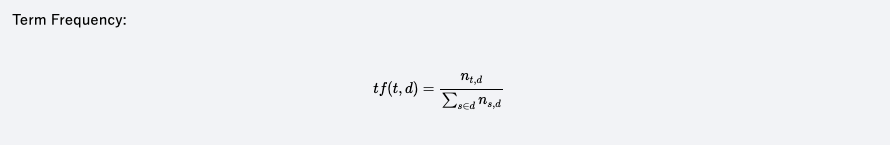

$n_{t, d}$ : サンプルd内のトークンtの出現回数(BoWと同じ)

$\sum_{s \in d}n_{s,d}$ : サンプルdの全トークンの出現回数の和
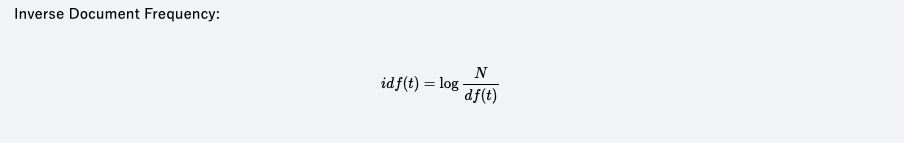

N : サンプル数

df(t) : トークンtが出現するサンプル数

＊logの底は任意の値

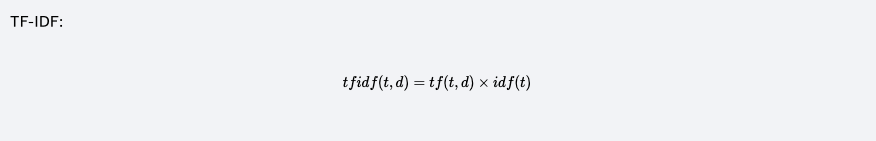

## IDF
IDFはそのトークンがデータセット内で珍しいほど値が大きくなる指標です。

サンプル数NをIMDB映画レビューデータセットの訓練データに合わせ25000として、トークンが出現するサンプル数df(t)を変化させてグラフを確認してみると、次のようになります。

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
n_samples = 25000
idf = np.log(n_samples/np.arange(1, n_samples))

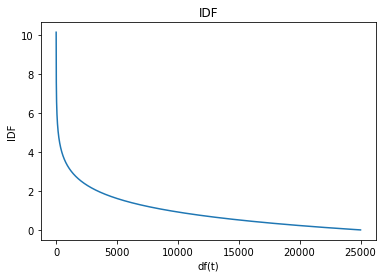

In [23]:
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

TF-IDFではこの数を出現回数に掛け合わせるので、珍しいトークンの登場に重み付けを行っていることになります。

## ストップワード
あまりにも頻繁に登場するトークンは、値を小さくするだけでなく、取り除くという前処理を加えることもあります。取り除くもののことをストップワードと呼びます。既存のストップワード一覧を利用したり、閾値によって求めたりします。

scikit-learnのCountVectorizerでは引数stop_wordsにリストで指定することで処理を行ってくれます。

In [24]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,best,ever,funny,i,movie,never,soooo,this,what
0,0,0,0,1,0,1,0,1,1,0
1,1,0,0,0,1,1,1,0,0,1
2,0,1,1,0,0,2,0,0,1,0


代表的な既存のストップワード一覧としては、NLTKという自然言語処理のライブラリのものがあげられます。あるデータセットにおいては特別重要な意味を持つ単語が一覧に含まれている可能性もあるため、使用する際は中身を確認することが望ましいです。

In [25]:
#はじめて使う場合はストップワードをダウンロード
import nltk

In [26]:
stop_words = nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/misakiryo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
from nltk.corpus import stopwords

In [28]:
stop_words = stopwords.words('english')

In [29]:
print('stop word : {}'.format(stop_words))

stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

逆に、登場回数が特に少ないトークンも取り除くことが多いです。すべてのトークンを用いるとベクトルの次元数が著しく大きくなってしまい計算コストが高まるためです。

scikit-learnのCountVectorizerでは引数max_featuresに最大の語彙数を指定することで処理を行ってくれます。以下の例では出現数が多い順に５個でベクトル化しています。

In [30]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features=5)

In [31]:
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()

In [32]:
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())

In [33]:
display(df)

,a,best,ever,movie,this
0,0,0,0,1,1
1,1,0,0,1,0
2,0,1,1,2,1


# 【問題２】TF-IDFの計算
IMDB映画レビューデータセットをTF-IDFによりベクトル化してください。NLTKのストップワードを利用し、最大の語彙数は５０００程度に設定してください。テキストクリーニングやステミングなどの前処理はこの問題では要求しません。

TF-IDFの計算にはscikit-learnの以下のどちらかのクラスを使用してください。

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

なお、scikit-learnでは標準的な式とは異なる式が採用されています。

また、デフォルトではnorm="l2"の引数が設定されており、各サンプルにL２正規化が行われます。norm=Noneとすることで正規化は行われなくなります。

In [34]:
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000, ngram_range=(1, 1))
x_train_array = vectorizer.fit_transform(x_train)
print(x_train_array.shape)

(25000, 5000)


In [35]:
vectorizer2 = TfidfVectorizer(stop_words=stop_words, max_features=5000, ngram_range=(2, 2))
x_train_array2 = vectorizer2.fit_transform(x_train)
print(x_train_array2.shape)

(25000, 5000)


In [36]:
vectorizer3 = TfidfVectorizer(stop_words=stop_words, max_features=5000, ngram_range=(1,2))
x_train_array3 = vectorizer3.fit_transform(x_train)
#print(vectorizer.get_feature_names())
print(x_train_array3.shape)

(25000, 5000)


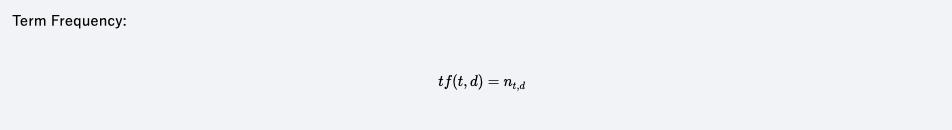

$n_{t,d}$ : サンプルd内のトークンtの出現回数
scikit-learnのTFは分母がなくなりBoWと同じ計算になります。

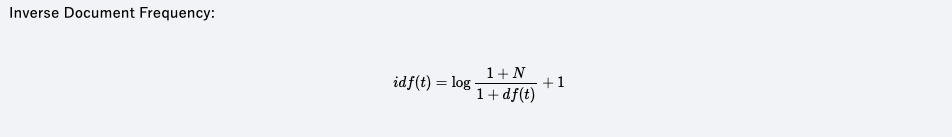

N : サンプル数

df(t) : トークンtが出現するサンプル数

＊logの底はネイピア数e

詳細は以下のドキュメントを確認してください。

https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

# 【問題３】TF-IDFを用いた学習
問題２で求めたベクトルを用いてIMDB映画レビューデータセットの学習・推定を行って下さい。モデルは２値分類が行える任意のものを利用してください。

ここでは精度の高さは求めませんが、最大の語彙数やストップワード、n-gramの数を変化させて影響を検証してみて下さい。

#### 【1】ngram_range(1, 1)

In [37]:
from sklearn.model_selection import train_test_split

y = np.copy(y_train)

# 学習データとテストデータを７５：２５で分割
X_train, X_val, y_train, y_val = train_test_split(x_train_array, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(18750, 5000)
(18750,)
(6250, 5000)
(6250,)


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [39]:
logistic = LogisticRegression(random_state=0)
logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_val)
print("ロジスティック回帰による予測値\n{}".format(y_pred))

acc = accuracy_score(y_val, y_pred)
print("ロジスティック回帰の正解率： {}".format(acc))

ロジスティック回帰による予測値
[0 0 1 ... 0 0 0]
ロジスティック回帰の正解率： 0.88176


In [40]:
# max_features = 10000 に変更

vectorizer = TfidfVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b', max_features = 10000)
X = vectorizer.fit_transform(x_train)

# 学習データとテストデータを７５：２５で分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

logistic = LogisticRegression(random_state=0)
logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_val)
print("max_features = 10000　の予測値\n{}".format(y_pred))

acc = accuracy_score(y_val, y_pred)
print("max_features = 10000　の正解率： {}".format(acc))

max_features = 10000　の予測値
[0 0 1 ... 0 0 0]
max_features = 10000　の正解率： 0.88848


In [41]:
# stop_words=["is", "was", "the", "this"] に変更

vectorizer = TfidfVectorizer(stop_words=["is", "was", "the", "this"], token_pattern=r'\b\w+\b', max_features = 5000)
X = vectorizer.fit_transform(x_train)

# 学習データとテストデータを７５：２５で分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

logistic = LogisticRegression(random_state=0)
logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_val)
print("stop_words の予測値\n{}".format(y_pred))

acc = accuracy_score(y_val, y_pred)
print("stop_words の正解率： {}".format(acc))

stop_words の予測値
[0 0 1 ... 0 0 0]
stop_words の正解率： 0.88432


In [42]:
# ngram_range=(2, 4) を追加

vectorizer = TfidfVectorizer(ngram_range=(2, 4), stop_words=["is"], token_pattern=r'\b\w+\b', max_features = 5000)
X = vectorizer.fit_transform(x_train)

# 学習データとテストデータを７５：２５で分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

logistic = LogisticRegression(random_state=0)
logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_val)
print("ngram_range=(2, 4) の予測値\n{}".format(y_pred))

acc = accuracy_score(y_val, y_pred)
print("ngram_range=(2, 4) の正解率： {}".format(acc))

ngram_range=(2, 4) の予測値
[0 0 1 ... 1 0 0]
ngram_range=(2, 4) の正解率： 0.84176


# 【問題４】TF-IDFのスクラッチ実装
以下の３文のTF-IDFを求められるプログラムをscikit-learnを使わずに作成してください。標準的な式と、scikit-learnの採用している式の２種類を作成してください。正規化は不要です。

This movie is SOOOO funny!!!

What a movie! I never

best movie ever!!!!! this movie

In [43]:
import string
import pandas as pd

def scratch_TF_IDF(sentence, n):
  #正規表現の準備
  kigo = string.punctuation #>>!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
  table = str.maketrans("", "", kigo)

  #全部小文字にする
  sentence = list(map(str.lower, sentence))

  #文ごとに単語単位に分ける
  sentence_words = []
  for s in sentence:
    result = s.translate(table)#正規表現
    sentence_words.append(result.split(' '))

  #################n-gram###############
  sentence_words_n_gram = []
  for s in sentence_words:
    n_gram_temp = []
    for i in range(len(s)-n+1):
      n_gram_temp.append(' '.join(s[i:i+n]))
    sentence_words_n_gram.append(n_gram_temp)

  #特徴量用に平坦化する
  feature_list = sum(sentence_words_n_gram, [])

  #BoWの表の作成
  n_appearances = []
  tf = []
  for s in sentence_words_n_gram:
    n_app_sentence = []
    n_td = []
    for f in feature_list:
      n_app_sentence.append(s.count(f))
    n_appearances.append(n_app_sentence)
    ##############TFの計算#############
    n_td = np.array(n_app_sentence)
    tf.append(n_td/np.sum(n_td))

  tf = np.array(tf)
  n_appearances = np.array(n_appearances)

  ###############IDFの計算#############
  idf = np.log((1+len(sentence_words))/(1+np.sum(tf, axis=0)))+1

  ###############TF-IDFの実装###########
  tf_idf = tf*idf

  df = pd.DataFrame(tf_idf, columns=feature_list)
  display(df)




#分類したい文字列
sentence = ['This movie is SOOOO funny!!!', 
            'What a movie! I never', 
            'best movie ever!!!!! this movie'
            ]

n=1
scratch_TF_IDF(sentence, n)

n=2
scratch_TF_IDF(sentence, n)

,this,movie,is,soooo,funny,what,a,movie,i,never,best,movie,ever,this,movie
0,0.245401,0.227538,0.253437,0.253437,0.253437,0.000000,0.000000,0.227538,0.000000,0.000000,0.000000,0.227538,0.000000,0.245401,0.227538
1,0.000000,0.255980,0.000000,0.000000,0.000000,0.283564,0.283564,0.255980,0.283564,0.283564,0.000000,0.255980,0.000000,0.000000,0.255980
2,0.184051,0.341307,0.000000,0.000000,0.000000,0.000000,0.000000,0.341307,0.000000,0.000000,0.192188,0.341307,0.192188,0.184051,0.341307


,this movie,movie is,is soooo,soooo funny,what a,a movie,movie i,i never,best movie,movie ever,ever this,this movie
0,0.409964,0.440795,0.440795,0.440795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.409964
1,0.000000,0.000000,0.000000,0.000000,0.540788,0.540788,0.540788,0.540788,0.000000,0.000000,0.000000,0.000000
2,0.409964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.440795,0.440795,0.440795,0.409964


In [44]:
# scikit-learnの数式を使用したもの

import string
import pandas as pd

def scratch_TF_IDF(sentence, n):

  #正規表現の準備
  kigo = string.punctuation# >>!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
  table = str.maketrans("", "", kigo)

  #全部小文字にする
  sentence = list(map(str.lower, sentence))

  #文ごとに単語単位に分ける
  sentence_words = []
  for s in sentence:
    result = s.translate(table)#正規表現
    sentence_words.append(result.split(' '))

  ############n-gram################
  sentence_words_n_gram = []
  for s in sentence_words:
    n_gram_temp = []
    for i in range(len(s)-n+1):
      n_gram_temp.append(' '.join(s[i:i+n]))
    sentence_words_n_gram.append(n_gram_temp)

  #特徴量用に平坦化する
  feature_list = sum(sentence_words_n_gram, [])

  #BoWの表の作成
  n_appearances = []
  tf = []
  for s in sentence_words_n_gram:
    n_app_sentence = []
    n_td = []
    for f in feature_list:
      n_app_sentence.append(s.count(f))
    n_appearances.append(n_app_sentence)
    ###########TFの計算#############
    n_td = np.array(n_app_sentence)
    tf.append(n_td/np.sum(n_td))

  tf = np.array(tf)
  n_appearances = np.array(n_appearances)

  ###########IDFの計算###############
  #分母を削除
  idf = np.log((1+len(sentence_words))) +1

  ############TF-IDFの実装############
  tf_idf = tf*idf
  
  df = pd.DataFrame(tf_idf, columns = feature_list)
  display(df)




#分類したい文字列
sentence = ['This movie is SOOOO funny!!!',
                        'What a movie! I never',
                        'best movie ever!!!!! this movie'
                       ]

n=1
scratch_TF_IDF(sentence, n)

n=2
scratch_TF_IDF(sentence, n)

,this,movie,is,soooo,funny,what,a,movie,i,never,best,movie,ever,this,movie
0,0.265144,0.265144,0.265144,0.265144,0.265144,0.000000,0.000000,0.265144,0.000000,0.000000,0.000000,0.265144,0.000000,0.265144,0.265144
1,0.000000,0.298287,0.000000,0.000000,0.000000,0.298287,0.298287,0.298287,0.298287,0.298287,0.000000,0.298287,0.000000,0.000000,0.298287
2,0.198858,0.397716,0.000000,0.000000,0.000000,0.000000,0.000000,0.397716,0.000000,0.000000,0.198858,0.397716,0.198858,0.198858,0.397716


,this movie,movie is,is soooo,soooo funny,what a,a movie,movie i,i never,best movie,movie ever,ever this,this movie
0,0.477259,0.477259,0.477259,0.477259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.477259
1,0.000000,0.000000,0.000000,0.000000,0.596574,0.596574,0.596574,0.596574,0.000000,0.000000,0.000000,0.000000
2,0.477259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.477259,0.477259,0.477259,0.477259


# Word2Vec
ニューラルネットワークを用いてベクトル化を行う手法がWord2Vecです。

BoWやTF-IDFはone-hot表現であったため、得られるベクトルの次元は語彙数文になります。そのため、語彙数を増やしにくいという問題があります。一方で、Word2Vecでは単語を任意の次元のベクトルに変換します。これをWord Embedding(単語埋め込み)や分散表現と呼びます。変換操作を「ベクトル空間に埋め込む」と言うことが多いです。

Word2VecにはCBoWとSkip-gramという２種類の仕組みがあるため順番に見ていきます。

## CBoW
CBoW(Continuous Bag-of-Words)によるWord2Vecではある単語とある単語の間に来る単語を推定できるように全結合層２層のニューラルネットワークを学習します。

単語はコーパス語彙数次元のone-hot表現を行っておきます。そのため、入力と出力の次元は語彙数と同じになります。一方で、中間のノード数をWord2Vecにより得たい任意の次元数とします。これにより全結合層の重みは「得たい次元のノード数×語彙数」になります。このネットワークにより学習を行った後、出力側の重みを取り出すことで、各語彙を表すベクトルを手に入れることができます。

間の単語の推定を行っているため、同じ箇所で代替可能な言葉は似たベクトルになるというメリットもあります。これはBoWやTF-IDFでは得られない情報です。

あるテキストは「そのテキストの長さ（単語数）×Word2Vecで得た分散表現の次元数」の配列になりますが、各入力の配列を揃える必要があるモデルに入力するためには、短いテキストは空白を表す単語を加えるパディングを行ったり、長いテキストは単語を消したりします。テキストを固定長にすると呼びます。

## ウィンドウサイズ
入力する単語は推定する前後１つずつでけでなく、複数個とする場合もあります。前後いくつを見るかの大きさをウィンドウサイズと呼びます。

## Skip-gram
CBoWとは逆にある単語の前後の単語を推定できるように全結合２層のニューラルネットワークを学習する方法がSkip-gramです。学習を行った行った後は入力例の重みを取り出し各語彙を表すベクトルとします。現在一般的に使われているのはCBoWよりもSki-gramです。

## 利用方法
PythonではGensimライブラリを用いて扱うことができます。

https://radimrehurek.com/gensim/models/word2vec.html

BoWの例と同じ文章で学習してみます。CountVectorizerと異なり前処理を自動的に行なってはくれないため、単語(トークン)はリストで分割しておきます。また、大文字は小文字に揃え、記号は取り除きます。

デフォルトのパラメータではCBoWで計算されます。また、ウィンドウサイズはwindow=5に設定されています。

In [45]:
from gensim.models import Word2Vec

In [46]:
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]

In [47]:
model = Word2Vec(min_count=1, size=10)#次元数を10に設定

In [48]:
model.build_vocab(sentences) #準備

In [49]:
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)#学習

<ipython-input-49-e03988f00e0b>:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)#学習


(5, 75)

In [50]:
print("語彙の一覧: {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
  print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧: dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[-0.01613223 -0.01959816  0.00396515 -0.03998699  0.00354138  0.02639589
  0.0151685  -0.04746579  0.04077582 -0.04506453]
movieのベクトル : 
[ 0.04607419 -0.02447941  0.00229141 -0.00965256  0.02604811  0.03443917
 -0.02467938  0.01267656 -0.00184841  0.04635685]
isのベクトル : 
[ 0.04546765 -0.01627956 -0.01968134 -0.03817088 -0.04511523  0.02483481
  0.03350194  0.04823795  0.04386638 -0.0067208 ]
veryのベクトル : 
[-0.02777174 -0.01839068  0.01374354 -0.04842786  0.02271224  0.02592997
 -0.01167312  0.03161254 -0.047166   -0.00171455]
goodのベクトル : 
[ 0.04784737  0.02314859 -0.00661387  0.03736703  0.04613693 -0.03865324
  0.02254428  0.03970955  0.01071091 -0.01854562]
filmのベクトル : 
[-0.00290351 -0.04753442  0.04940791 -0.04621698 -0.00913289  0.04173002
  0.01929883 -0.04744623 -0.00312095  0.02764383]
aのベクトル : 
[ 0.02731549 -0.03734412  0.02302057  0.02417382 -0.01206679 -0.01964124
 -0.03545899 -0.04480369

このようにしてベクトルが得られます。

## 単語の距離
ベクトル間で計算を行うことで、ある単語に似たベクトルを持つ単語を見つけることができます。例えばgoodに似たベクトルの単語を３つ探します。

In [51]:
model.wv.most_similar(positive='good', topn=3)

[('bad', 0.16201363503932953),
 ('is', 0.06426012516021729),
 ('movie', 0.022462841123342514)]

今の例では３文しか学習していませので効果を発揮しませんが、大きなコーパスで学習することで、並列関係のものが近くに来たりなど面白い結果が得られます。

## 可視化
２次元に圧縮することで単語ごとの位置関係を可視化することができます。以下はt-SNEを用いた例です。

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [53]:
vocabs = model.wv.vocab.keys()

In [54]:
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)

In [55]:
vectors_tsne = tsne_model.fit_transform(model[vocabs])

<ipython-input-55-f77848a26fce>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors_tsne = tsne_model.fit_transform(model[vocabs])


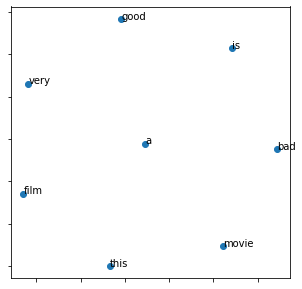

In [56]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
  plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))

ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

# IMDB映画映画レビューデータセットの分散表現
IMDB映画レビューデータセットの訓練データをコーパスとしてWord2Vecを学習させ分散表現を獲得しましょう。

## 【問題５】コーパスの前処理
コーパスの前処理として、特殊文字(!など)やURLの除去、大文字の小文字化といったことを行ってください。また、単語(トークン)はリストで分割してください。

In [57]:
print(x_train[0])
print("Label:", y_train[0])

Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.
Label: 1


In [58]:
print(x_train[3])
print("Label:", y_train[3])

There are a lot of highly talented filmmakers/actors in Germany now. None of them are associated with this "movie".<br /><br />Why in the world do producers actually invest money in something like this this? You could have made 10 good films with the budget of this garbage! It's not entertaining to have seven grown men running around as dwarfs, pretending to be funny. What IS funny though is that the film's producer (who happens to be the oldest guy of the bunch) is playing the YOUNGEST dwarf.<br /><br />The film is filled with moments that scream for captions saying "You're supposed to laugh now!". It's hard to believe that this crap's supposed to be a comedy.<br /><br />Many people actually stood up and left the cinema 30 minutes into the movie. I should have done the same instead of wasting my time...<br /><br />Pain!
Label: 0


In [59]:
!pip install neologdn

     |████████████████████████████████| 59 kB 7.8 MB/s  eta 0:00:01
  Created wheel for neologdn: filename=neologdn-0.4-cp38-cp38-macosx_10_9_x86_64.whl size=58986 sha256=6799b1b17b1697e60d48fa4e38aedb9ecee58afa490e48fcdecb624eda6d40d7
  Stored in directory: /Users/misakiryo/Library/Caches/pip/wheels/e4/8c/b7/1050ae9a994e00e77c9f36ffbaa6f6fa905fd713f1dfd66306
Successfully built neologdn


In [60]:
import re

text = x_train[3]
pattern = r'(http|https)://([-\w]+\.)+[-\w]+(/[-\w./?%&=]*)?'
x_train_norm = re.sub(pattern, '', text)

print(x_train_norm)

There are a lot of highly talented filmmakers/actors in Germany now. None of them are associated with this "movie".<br /><br />Why in the world do producers actually invest money in something like this this? You could have made 10 good films with the budget of this garbage! It's not entertaining to have seven grown men running around as dwarfs, pretending to be funny. What IS funny though is that the film's producer (who happens to be the oldest guy of the bunch) is playing the YOUNGEST dwarf.<br /><br />The film is filled with moments that scream for captions saying "You're supposed to laugh now!". It's hard to believe that this crap's supposed to be a comedy.<br /><br />Many people actually stood up and left the cinema 30 minutes into the movie. I should have done the same instead of wasting my time...<br /><br />Pain!


In [62]:
#<b>absorbed</b>にマッチさせて置換する
pattern = r'<.+?>'
x_train_norm = re.sub(pattern, '', x_train_norm)

print(x_train_norm)

There are a lot of highly talented filmmakers/actors in Germany now. None of them are associated with this "movie".Why in the world do producers actually invest money in something like this this? You could have made 10 good films with the budget of this garbage! It's not entertaining to have seven grown men running around as dwarfs, pretending to be funny. What IS funny though is that the film's producer (who happens to be the oldest guy of the bunch) is playing the YOUNGEST dwarf.The film is filled with moments that scream for captions saying "You're supposed to laugh now!". It's hard to believe that this crap's supposed to be a comedy.Many people actually stood up and left the cinema 30 minutes into the movie. I should have done the same instead of wasting my time...Pain!


In [63]:
pattern = r'\'s'
x_train_norm = re.sub(pattern, '', x_train_norm)

print(x_train_norm)

There are a lot of highly talented filmmakers/actors in Germany now. None of them are associated with this "movie".Why in the world do producers actually invest money in something like this this? You could have made 10 good films with the budget of this garbage! It not entertaining to have seven grown men running around as dwarfs, pretending to be funny. What IS funny though is that the film producer (who happens to be the oldest guy of the bunch) is playing the YOUNGEST dwarf.The film is filled with moments that scream for captions saying "You're supposed to laugh now!". It hard to believe that this crap supposed to be a comedy.Many people actually stood up and left the cinema 30 minutes into the movie. I should have done the same instead of wasting my time...Pain!


In [64]:
#正規表現の準備 
kigo = string.punctuation#>>!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
table = str.maketrans("", "", kigo)
x_train_norm = x_train_norm.translate(table)

print(x_train_norm)

There are a lot of highly talented filmmakersactors in Germany now None of them are associated with this movieWhy in the world do producers actually invest money in something like this this You could have made 10 good films with the budget of this garbage It not entertaining to have seven grown men running around as dwarfs pretending to be funny What IS funny though is that the film producer who happens to be the oldest guy of the bunch is playing the YOUNGEST dwarfThe film is filled with moments that scream for captions saying Youre supposed to laugh now It hard to believe that this crap supposed to be a comedyMany people actually stood up and left the cinema 30 minutes into the movie I should have done the same instead of wasting my timePain


In [65]:
#文ごとに単語単位に分ける
x_train_norm = x_train_norm.split(' ')

print(x_train_norm)

['There', 'are', 'a', 'lot', 'of', 'highly', 'talented', 'filmmakersactors', 'in', 'Germany', 'now', 'None', 'of', 'them', 'are', 'associated', 'with', 'this', 'movieWhy', 'in', 'the', 'world', 'do', 'producers', 'actually', 'invest', 'money', 'in', 'something', 'like', 'this', 'this', 'You', 'could', 'have', 'made', '10', 'good', 'films', 'with', 'the', 'budget', 'of', 'this', 'garbage', 'It', 'not', 'entertaining', 'to', 'have', 'seven', 'grown', 'men', 'running', 'around', 'as', 'dwarfs', 'pretending', 'to', 'be', 'funny', 'What', 'IS', 'funny', 'though', 'is', 'that', 'the', 'film', 'producer', 'who', 'happens', 'to', 'be', 'the', 'oldest', 'guy', 'of', 'the', 'bunch', 'is', 'playing', 'the', 'YOUNGEST', 'dwarfThe', 'film', 'is', 'filled', 'with', 'moments', 'that', 'scream', 'for', 'captions', 'saying', 'Youre', 'supposed', 'to', 'laugh', 'now', 'It', 'hard', 'to', 'believe', 'that', 'this', 'crap', 'supposed', 'to', 'be', 'a', 'comedyMany', 'people', 'actually', 'stood', 'up', 'a

In [66]:
#全部小文字にする
sentence_words = []
for s in x_train_norm:
  sentence_words.append(s.lower())

print(sentence_words)

['there', 'are', 'a', 'lot', 'of', 'highly', 'talented', 'filmmakersactors', 'in', 'germany', 'now', 'none', 'of', 'them', 'are', 'associated', 'with', 'this', 'moviewhy', 'in', 'the', 'world', 'do', 'producers', 'actually', 'invest', 'money', 'in', 'something', 'like', 'this', 'this', 'you', 'could', 'have', 'made', '10', 'good', 'films', 'with', 'the', 'budget', 'of', 'this', 'garbage', 'it', 'not', 'entertaining', 'to', 'have', 'seven', 'grown', 'men', 'running', 'around', 'as', 'dwarfs', 'pretending', 'to', 'be', 'funny', 'what', 'is', 'funny', 'though', 'is', 'that', 'the', 'film', 'producer', 'who', 'happens', 'to', 'be', 'the', 'oldest', 'guy', 'of', 'the', 'bunch', 'is', 'playing', 'the', 'youngest', 'dwarfthe', 'film', 'is', 'filled', 'with', 'moments', 'that', 'scream', 'for', 'captions', 'saying', 'youre', 'supposed', 'to', 'laugh', 'now', 'it', 'hard', 'to', 'believe', 'that', 'this', 'crap', 'supposed', 'to', 'be', 'a', 'comedymany', 'people', 'actually', 'stood', 'up', 'a

In [71]:
#正規表現用の関数を作成

def regular_expression(text):

  #URLの削除
  pattern = r'(http|https)://([-\w]+\.)+[-\w]+(/[-\w./?%&=]*)?'
  x_train_norm = re.sub(pattern, '', text)

  #HTMLタグの削除
  #<b>absorbed</b>にマッチさせて置換する
  pattern = r'<.+?>'
  x_train_norm = re.sub(pattern, '', x_train_norm)

  #'sを削除
  #pattern = r'\'s'
  #x_train_norm = re.sub(pattern, '', x_train_norm)

  #正規表現
  kigo = string.punctuation#>>!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
  table = str.maketrans("", "", kigo)
  x_train_norm = x_train_norm.translate(table)

  #文ごとに単語単位に分ける
  x_train_norm = x_train_norm.split(' ')

  #全部小文字にする
  sentence_words = []
  for s in x_train_norm:
    sentence_words.append(s.lower())

  return sentence_words

In [72]:
x_train_reg = []
for i in range(len(x_train)):
  x_train_reg.append(regular_expression(x_train[i]))

In [73]:
print(x_train_reg[0:5])

[['zero', 'day', 'leads', 'you', 'to', 'think', 'even', 'rethink', 'why', 'two', 'boysyoung', 'men', 'would', 'do', 'what', 'they', 'did', '', 'commit', 'mutual', 'suicide', 'via', 'slaughtering', 'their', 'classmates', 'it', 'captures', 'what', 'must', 'be', 'beyond', 'a', 'bizarre', 'mode', 'of', 'being', 'for', 'two', 'humans', 'who', 'have', 'decided', 'to', 'withdraw', 'from', 'common', 'civility', 'in', 'order', 'to', 'define', 'their', 'ownmutual', 'world', 'via', 'coupled', 'destructionit', 'is', 'not', 'a', 'perfect', 'movie', 'but', 'given', 'what', 'moneytime', 'the', 'filmmaker', 'and', 'actors', 'had', '', 'it', 'is', 'a', 'remarkable', 'product', 'in', 'terms', 'of', 'explaining', 'the', 'motives', 'and', 'actions', 'of', 'the', 'two', 'young', 'suicidemurderers', 'it', 'is', 'better', 'than', 'elephant', '', 'in', 'terms', 'of', 'being', 'a', 'film', 'that', 'gets', 'under', 'our', 'rationalistic', 'skin', 'it', 'is', 'a', 'far', 'far', 'better', 'film', 'than', 'almost'

# 【問題６】Word2Vecの学習
Word2Vecの学習を行って下さい

In [74]:
from gensim.models import Word2Vec

sentences = x_train_reg
model = Word2Vec(min_count=1, size=5000)#次元数を１０に設定
model.build_vocab(sentences) #準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) #学習

<ipython-input-74-517756fe2e7c>:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) #学習


(21864320, 28712195)

In [75]:
print("語彙の一覧:{}".format(model.wv.vocab.keys()))

count = 0
for vocab in model.wv.vocab.keys():
  if count > 50:
    break
  else:
    print("{}のベクトル: \n{}".format(vocab, model.wv[vocab]))
    count += 1

語彙の一覧:dict_keys(['zero', 'day', 'leads', 'you', 'to', 'think', 'even', 'rethink', 'why', 'two', 'boysyoung', 'men', 'would', 'do', 'what', 'they', 'did', '', 'commit', 'mutual', 'suicide', 'via', 'slaughtering', 'their', 'classmates', 'it', 'captures', 'must', 'be', 'beyond', 'a', 'bizarre', 'mode', 'of', 'being', 'for', 'humans', 'who', 'have', 'decided', 'withdraw', 'from', 'common', 'civility', 'in', 'order', 'define', 'ownmutual', 'world', 'coupled', 'destructionit', 'is', 'not', 'perfect', 'movie', 'but', 'given', 'moneytime', 'the', 'filmmaker', 'and', 'actors', 'had', 'remarkable', 'product', 'terms', 'explaining', 'motives', 'actions', 'young', 'suicidemurderers', 'better', 'than', 'elephant', 'film', 'that', 'gets', 'under', 'our', 'rationalistic', 'skin', 'far', 'almost', 'anything', 'are', 'likely', 'see', 'flawed', 'honest', 'with', 'terrible', 'honesty', 'words', 'cant', 'describe', 'how', 'bad', 'this', 'i', 'explain', 'by', 'writing', 'only', 'too', 'yourself', 'get', 'a

# 【問題７】(アドバンス課題)ベクトルの可視化
得られたベクトルをt-SNEにより可視化してください。また、いくつかの単語を選びwv.most_similarを用いて似ている単語を調べて下さい。

## 学習済みベクトル
巨大なコーパスで学習して得たベクトルも公開されているため、自分で学習をせずに利用することもできます。オリジナルのWord2Vecの他に同じ作者の発展系であるFastTextやスタンフォード大のGloVeがあり、それぞれ公開されています。

# 【問題８】(アドバンス課題)Word2Vecを用いた映画のレビュー分類

問題６で学習して得たベクトルや公開されている学習済みベクトルを用いてIMDB映画レビューデータセットの感情分類の学習・推定を行って下さい。